In [1]:
from processing import msevn
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

msevn.configure_mpl()

In [2]:
root = './matlab/output/spherical'

dphi = np.linspace(0, 180, 30)
dtheta0_90 = np.linspace(0, 90, 25)
dtheta90_180 = np.linspace(90, 180, 25)

eint0_90_global = np.zeros(shape=(dtheta0_90.size, dphi.size))
eint90_180_global = np.zeros(shape=(dtheta90_180.size, dphi.size))

files = list(filter(lambda x: x.endswith('.mat'), os.listdir(root)))
#files = filter(lambda x: re.search('15deg', x), files)

fname = files[1]

fname

'cylinder_16edge_2d_relative_83wlen_20radius_0nonreg_15deg_theta0_0deg_phi0_TEpol_83wav_800bw_spherical.mat'

In [3]:
data = scipy.io.loadmat(os.path.join(root, fname))

In [4]:
field = data['eField3DAbs']
#field = np.transpose(field, (1, 0, 2))
#field = np.nan_to_num(field)
field = field.reshape(-1, 1)

In [5]:
X = data['x'].reshape(-1, 1)
Y = data['y'].reshape(-1, 1)
Z = data['z'].reshape(-1, 1)

In [6]:
coords = np.concatenate([X, Y, Z], axis=1)

In [189]:
new_coords = []
exclude_idx = []

for i, row in enumerate(tqdm(coords)):
    if list(row) in new_coords:
        exclude_idx.append(i)
    else:
        new_coords.append(list(row))

  7%|▋         | 59687/818100 [00:29<06:13, 2027.88it/s] 


KeyboardInterrupt: 

In [196]:
np.where(coords == np.array([0, 0, 6000]))

(array([     0,      0,      0, ..., 817920, 818010, 818010]),
 array([0, 1, 2, ..., 1, 0, 1]))

In [199]:
coords

array([[ 0.00000000e+00,  0.00000000e+00,  6.00000000e+03],
       [ 2.11748783e+02,  0.00000000e+00,  5.99626237e+03],
       [ 4.23233754e+02,  0.00000000e+00,  5.98505415e+03],
       ...,
       [ 5.64311672e+02, -1.38216497e-13, -7.98007220e+03],
       [ 2.82331711e+02, -6.91513253e-14, -7.99501650e+03],
       [ 9.79717439e-13, -2.39961565e-28, -8.00000000e+03]])

In [198]:
set(tuple(map(tuple, coords)))

{(-6098.535083015797, -2005.3613626457432, 1986.1509626493976),
 (105.24195838770179, 450.60885383812825, -6543.6592049890105),
 (-1594.9605986982194, 1460.0742448946712, 7452.642745227727),
 (845.8831424328171, -5280.361841564766, -3799.4552940513377),
 (913.9058480105986, -779.1555884839864, -6733.7428425732305),
 (746.7516539253843, -1921.6630683537392, 6269.734684903739),
 (2080.957825480551, 295.7894498249341, 5705.131298221236),
 (2051.4915318244985, -1105.2891004466164, -7086.700113542712),
 (3550.486659941774, 5390.574267097618, -571.0985453321405),
 (-2920.5954085839403, 2317.0743220595987, -6919.601798182498),
 (1049.6424498151755, -1031.278473435142, -6843.589367998001),
 (6305.582376283102, -3995.4026242395457, 1195.8213771829385),
 (282.63600132633564, -3194.4654250348467, -6491.002044292637),
 (6548.620781338464, 2412.6315454988667, -123.1863948890375),
 (-5590.516907289793, 1838.3114060160103, -4840.571441867004),
 (5759.069012337142, 3649.115667985582, -2376.02166505279

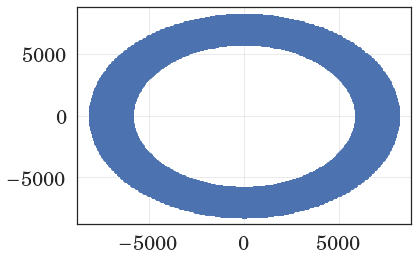

In [34]:
idxs = np.where(X**2 + Y**2 + Z**2 == 6000**2)[0]
idx2 = np.where(np.abs(Y) < 300)[0]

idxs = list(set(idxs).intersection(set(idx2)))

plt.scatter(X[idx2], Z[idx2])


In [19]:
idx2

array([], dtype=int64)

In [93]:
from tqdm import tqdm

def calc_e_int_sph(
    
        field: np.ndarray, 
        dphis: np.ndarray, # arrs args
        dthetas: np.ndarray, # arrs args
        coords: np.ndarray,
        cylw: int = 400

    ):

    x = coords[:, 0]
    y = coords[:, 1]
    z = coords[:, 2]

    globnrm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    #gl = np.where(globnrm >= 7900)[0]

    #x = x[gl]
    #y = y[gl]
    #z = z[gl]

    output = []

    coords2 = {}

    for p in tqdm(dphis):

        row = []

        row2 = {}

        x1 = x * np.cos(np.pi * p / 180) - y * np.sin(np.pi * p / 180)
        y1 = x * np.sin(np.pi * p / 180) + y * np.cos(np.pi * p / 180)

        for t in dthetas:

            x2 = x1 * np.cos(np.pi * t / 180) + z * np.sin(np.pi * t / 180)
            y2 = y1
            z2 = z * np.cos(np.pi * t / 180) - x1 * np.sin(np.pi * t / 180)
            cylnrm = np.sqrt(x2 ** 2 + y2 ** 2)

            cylidx = np.where(cylnrm <= cylw)[0]
            cylzb0 = np.where(z2 >= 0)[0]

            stbl = list(set(cylidx).intersection(set(cylzb0)))
            #stbl = gl[stbl]
            
            #print(f'{p=}, {t=}', cylidx)
            val = np.sum(field[stbl])
            row.append(val)

            row2[t] = cylidx
        
        coords2[p] = row2
        output.append(row)
    
    return (np.array(output).T, coords2)

In [213]:
#x0 = coords[:, 0]
#y0 = coords[:, 1]
#z0 = coords[:, 2]
#cc = np.linspace(-100, 100, 51)

r = 8000
phi = np.arange(0, 2 * np.pi, 2 * np.pi / 360)
theta = np.arange(0, np.pi + np.pi / 180, np.pi / 180)

[r, phi, theta] = np.meshgrid(r, phi, theta)

x0 = r * np.cos(phi) * np.sin(theta)
y0 = r * np.sin(phi) * np.sin(theta)
z0 = r * np.cos(theta)

#[x0, y0, z0] = np.meshgrid(cc, np.zeros(1), cc)

x0 = x0.reshape(-1, 1)
y0 = y0.reshape(-1, 1)
z0 = z0.reshape(-1, 1)

#x0 = coords[:, 0]
#y0 = coords[:, 1]
#z0 = coords[:, 2]

p = 0
t = 0
cylw = 1

x1 = x0 * np.cos(np.pi * p / 180) - y0 * np.sin(np.pi * p / 180)
y1 = x0 * np.sin(np.pi * p / 180) + y0 * np.cos(np.pi * p / 180)

x2 = x1 * np.cos(np.pi * t / 180) + z0 * np.sin(np.pi * t / 180)
y2 = y1
z2 = z0 * np.cos(np.pi * t / 180) - x1 * np.sin(np.pi * t / 180)
cylnrm = np.sqrt(x2 ** 2 + y2 ** 2)

ffsf = np.where(z2 >= 0)[0]
cylidx = np.where(cylnrm < cylw)[0]

cylidx = list(set(ffsf).intersection(set(cylidx)))

Text(0.5, 1.0, 'len(cylidx)=360')

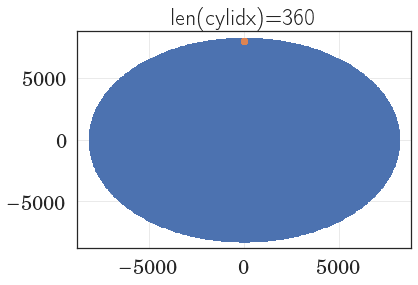

In [214]:
#adp = np.where(abs(y0[cylidx]) < 10)[0]
#adp2 = np.where(abs(y0) < 10)[0]

plt.scatter(y0, z0)
plt.scatter(y0[cylidx], z0[cylidx])
plt.gca().set_title(f'{len(cylidx)=}')
#plt.gca().set_xlim(-cylw*1.5, cylw*1.5)
#plt.gca().set_ylim(-cylw*1.5, cylw*1.5)

In [165]:
z0[10101]

array([4587.92464447])

In [162]:
coords[10101]

array([4189.4604147 ,  296.2581482 , 4587.92464447])

In [39]:
x0[cylidx][].mean()

157.5206526391295

In [183]:
aas = list(zip(x0[cylidx], z0[cylidx], y0[cylidx]))

len(set(aas))

101

In [113]:
dphi = np.linspace(0, 180, 45)
dtheta90_180 = np.linspace(90, 180, 50)
dtheta0_90 = np.linspace(0, 90, 45)

vava, idxsx = calc_e_int_sph(
    field=field, 
    dphis=dphi,
    dthetas=dtheta0_90,
    coords=coords,
    cylw=10
    )

100%|██████████| 45/45 [01:00<00:00,  1.34s/it]


dict_keys([0.0, 2.0454545454545454, 4.090909090909091, 6.136363636363637, 8.181818181818182, 10.227272727272727, 12.272727272727273, 14.318181818181818, 16.363636363636363, 18.40909090909091, 20.454545454545453, 22.5, 24.545454545454547, 26.59090909090909, 28.636363636363637, 30.68181818181818, 32.72727272727273, 34.77272727272727, 36.81818181818182, 38.86363636363636, 40.90909090909091, 42.95454545454545, 45.0, 47.04545454545455, 49.09090909090909, 51.13636363636363, 53.18181818181818, 55.22727272727273, 57.27272727272727, 59.31818181818182, 61.36363636363636, 63.40909090909091, 65.45454545454545, 67.5, 69.54545454545455, 71.5909090909091, 73.63636363636364, 75.68181818181819, 77.72727272727272, 79.77272727272727, 81.81818181818181, 83.86363636363636, 85.9090909090909, 87.95454545454545, 90.0])

18180


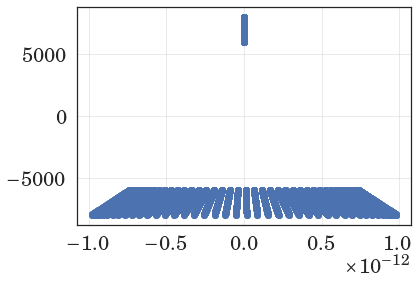

In [123]:
plotidx = idxsx[0][list(idxsx[0].keys())[0]]
print(plotidx.size)

plt.scatter(X[plotidx], Z[plotidx])

In [129]:
Z[plotidx].size

18180

In [128]:
np.where(Z[plotidx][:, 0] < 0)[0].size

9090

/home/misery7100/GitLibrary/Magistracy/Article-I/computations/processing/msevn/mstm/plotting/polar.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])


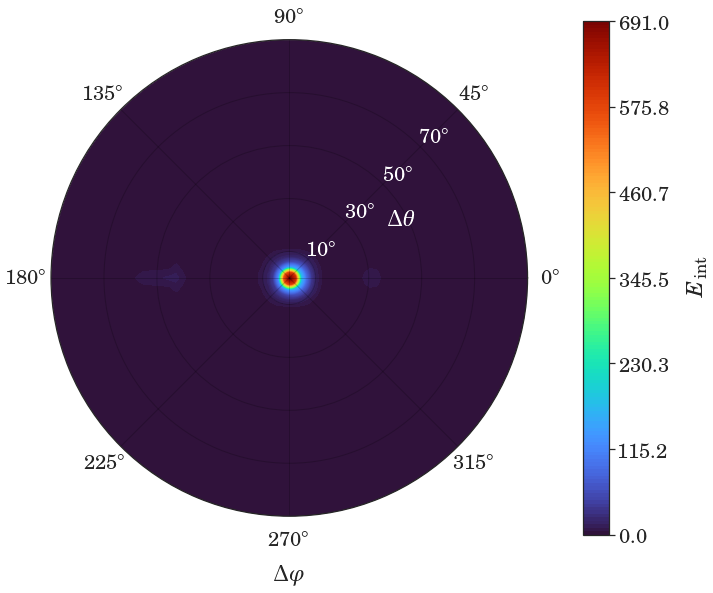

In [84]:
fig = msevn.mstm_polar_plot.e_int(vava, kind='t', dtheta=dtheta0_90, dphi=dphi)